In [1]:
import numpy as np
from keras.datasets import mnist

In [2]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train.shape

(60000, 28, 28)

## Display the images

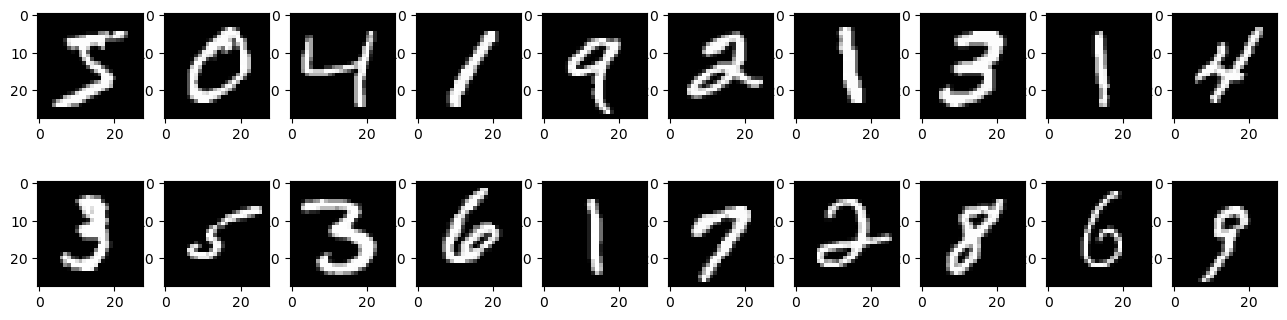

In [3]:
from matplotlib import pyplot as plt

def visualize_data(data, row, column):
    data = data.reshape(data.shape[0], 28, 28)
    
    count = 0
    
    fig, axes = plt.subplots(row, column, figsize=(16, 4))
    for i in range(row):
        for ix in range(column):
            axes[i, ix].imshow(data[count], cmap='gray')
            count += 1
            
visualize_data(X_train, 2, 10)

## Normalize the images

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## Add noise to images

In [5]:
# prepare source data
noise_factor = 0.1
X_train_noise = X_train + noise_factor * np.random.normal(loc=0, scale=1., size=X_train.shape)
X_test_noise = X_test + noise_factor * np.random.normal(loc=0, scale=1., size=X_test.shape)

## Display noisy data

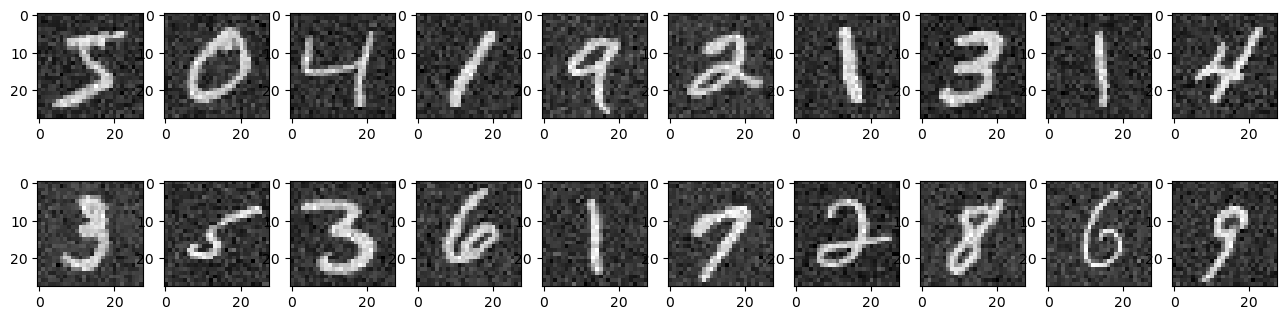

In [6]:
visualize_data(X_train_noise, 2, 10)

## Reshape dataset into 3D cause we need to??

In [7]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train_noise = X_train_noise.reshape(X_train_noise.shape[0], 28, 28, 1)
X_test_noise = X_test_noise.reshape(X_test_noise.shape[0], 28, 28, 1)

X_train.shape, X_train_noise.shape

((60000, 28, 28, 1), (60000, 28, 28, 1))

## Create the model

In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, AveragePooling2D
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

In [9]:
# this doesn't work on tensorflow > 2.10 on windows.
# devices = tf.config.experimental.list_physical_devices("GPU")
# devices
# #tf.config.experimental.set_memory_growth(devices[0], enable=True)

## Create Network

In [53]:
cbdnet_input = Input(shape=X_train.shape[1:])

# used to be 16 for 256 photo
# Noise estimation subnetwork
x = Conv2D(4, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(cbdnet_input)
x = Conv2D(4, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(x)
x = Conv2D(4, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(x)
x = Conv2D(4, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(x)

# idk wtf this does. but this is the last dimension. needs to be 1 for the mnist i guess. channels, maybe?
x = Conv2D(1, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(x)

# used to be 32 for 256 photo
# Non-blind estimation subnetwork
x = tf.keras.layers.Concatenate()([x, cbdnet_input])
conv1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
conv2 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)

# used to be 64 for 256 photo
pool1 = AveragePooling2D(pool_size=(2, 2), padding='same')(conv2)
conv3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
conv4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
conv5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

# the 32 is the actual size of the photo, i think. this was taken from a tutorial
# that used 256x256 photos, and 256 was in conv6-11.
# i changed all 4, 16, 8, etc values in relation to going from 256 -> 32.
pool2 = AveragePooling2D(pool_size=(2, 2), padding='same')(conv5)
conv6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
conv9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
conv10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
conv11 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv10)

# used to be 64 for 256 photo
upsample1 = Conv2DTranspose(16, (3, 3,), strides=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv11)
add1 = tf.keras.layers.Add()([upsample1, conv5])
conv12 = Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(add1)
conv13 = Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(conv12)
conv14 = Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(conv13)

# used to be 32 and 64 for 256 photo
upsample2 = Conv2DTranspose(8, (3, 3,), strides=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv14)
add2 = tf.keras.layers.Add()([upsample2, conv2])
conv15 = Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(add2)
conv16 = Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(conv15)

# idk wtf this does. but this is the last dimension. needs to be 1 for the mnist i guess. channels, maybe?
cbdnet_output = Conv2D(1, (1, 1), kernel_initializer='he_normal', padding='same')(conv16)
cbdnet_output = tf.keras.layers.Add()([cbdnet_output, cbdnet_input])

In [54]:
cbdnet = Model(cbdnet_input, cbdnet_output, name='Denoising_Model')
cbdnet.summary()

Model: "Denoising_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_330 (Conv2D) │ (None, 28, 28, 4) │         40 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_331 (Conv2D) │ (None, 28, 28, 4) │        148 │ conv2d_330[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_332 (Conv2D) │ (None, 28, 28, 4) │        148 │ conv2d_331[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_333 (Conv2D) │ (None, 28, 28, 4) │        148 │ conv2d_332[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_334 (Conv2D) │ (None, 28, 28, 1) │         37 │ conv2d_333[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 28, 28, 2) │          0 │ conv2d_334[0][0], │
│ (Concatenate)       │                   │            │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_335 (Conv2D) │ (None, 28, 28, 8) │        152 │ concatenate_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_336 (Conv2D) │ (None, 28, 28, 8) │        584 │ conv2d_335[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 14, 14, 8) │          0 │ conv2d_336[0][0]  │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_337 (Conv2D) │ (None, 14, 14,    │      1,168 │ average_pooling2… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_338 (Conv2D) │ (None, 14, 14,    │      2,320 │ conv2d_337[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_339 (Conv2D) │ (None, 14, 14,    │      2,320 │ conv2d_338[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 7, 7, 16)  │          0 │ conv2d_339[0][0]  │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_340 (Conv2D) │ (None, 7, 7, 32)  │      4,640 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_341 (Conv2D) │ (None, 7, 7, 32)  │      9,248 │ conv2d_340[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_342 (Conv2D) │ (None, 7, 7, 32)  │      9,248 │ conv2d_341[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_343 (Conv2D) │ (None, 7, 7, 32)  │      9,248 │ conv2d_342[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_344 (Conv2D) │ (None, 7, 7, 32)  │      9,248 │ conv2d_343[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_345 (Conv2D) │ (None, 7, 7, 32)  │      9,248 │ conv2d_344[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_27 │ (None, 14, 14,    │      4,624 │ conv2d_345[0][0]  │
│ (Conv2DTranspose)   │ 16)               │            │                 

 Total params: 74,194 (289.82 KB)

 Trainable params: 74,194 (289.82 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
cbdnet.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam')

## Train the model

In [45]:
checkpoint = ModelCheckpoint('cbdnet_denoising_model.keras', save_best_only=True, save_weights_only=False, verbose=1)
history = cbdnet.fit(X_train_noise, X_train, batch_size=128, epochs=25, callbacks=checkpoint, validation_split=0.25, verbose=2)

Epoch 1/25

Epoch 1: val_loss improved from inf to 0.00171, saving model to cbdnet_denoising_model.keras
352/352 - 6s - 18ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 2/25

Epoch 2: val_loss improved from 0.00171 to 0.00140, saving model to cbdnet_denoising_model.keras
352/352 - 6s - 18ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/25

Epoch 3: val_loss improved from 0.00140 to 0.00121, saving model to cbdnet_denoising_model.keras
352/352 - 6s - 18ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/25

Epoch 4: val_loss improved from 0.00121 to 0.00113, saving model to cbdnet_denoising_model.keras
352/352 - 6s - 18ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/25

Epoch 5: val_loss improved from 0.00113 to 0.00108, saving model to cbdnet_denoising_model.keras
352/352 - 7s - 18ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/25

Epoch 6: val_loss improved from 0.00108 to 0.00107, saving model to cbdnet_denoising_model.keras
352/352 - 6s - 18ms/step - loss: 0.0011 - val_loss: 0.0

## Load best model

In [55]:
from keras.models import load_model
cbdnet = load_model('cbdnet_denoising_model.keras')
cbdnet.summary()

Model: "Denoising_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_267 (Conv2D) │ (None, 28, 28, 4) │         40 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_268 (Conv2D) │ (None, 28, 28, 4) │        148 │ conv2d_267[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_269 (Conv2D) │ (None, 28, 28, 4) │        148 │ conv2d_268[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_270 (Conv2D) │ (None, 28, 28, 4) │        148 │ conv2d_269[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_271 (Conv2D) │ (None, 28, 28, 1) │         37 │ conv2d_270[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 28, 28, 2) │          0 │ conv2d_271[0][0], │
│ (Concatenate)       │                   │            │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_272 (Conv2D) │ (None, 28, 28, 8) │        152 │ concatenate_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_273 (Conv2D) │ (None, 28, 28, 8) │        584 │ conv2d_272[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 14, 14, 8) │          0 │ conv2d_273[0][0]  │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_274 (Conv2D) │ (None, 14, 14,    │      1,168 │ average_pooling2… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_275 (Conv2D) │ (None, 14, 14,    │      2,320 │ conv2d_274[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_276 (Conv2D) │ (None, 14, 14,    │      2,320 │ conv2d_275[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 7, 7, 16)  │          0 │ conv2d_276[0][0]  │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_277 (Conv2D) │ (None, 7, 7, 32)  │      4,640 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_278 (Conv2D) │ (None, 7, 7, 32)  │      9,248 │ conv2d_277[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_279 (Conv2D) │ (None, 7, 7, 32)  │      9,248 │ conv2d_278[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_280 (Conv2D) │ (None, 7, 7, 32)  │      9,248 │ conv2d_279[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_281 (Conv2D) │ (None, 7, 7, 32)  │      9,248 │ conv2d_280[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_282 (Conv2D) │ (None, 7, 7, 32)  │      9,248 │ conv2d_281[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_21 │ (None, 14, 14,    │      4,624 │ conv2d_282[0][0]  │
│ (Conv2DTranspose)   │ 16)               │            │                 

 Total params: 222,584 (869.47 KB)

 Trainable params: 74,194 (289.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 148,390 (579.65 KB)

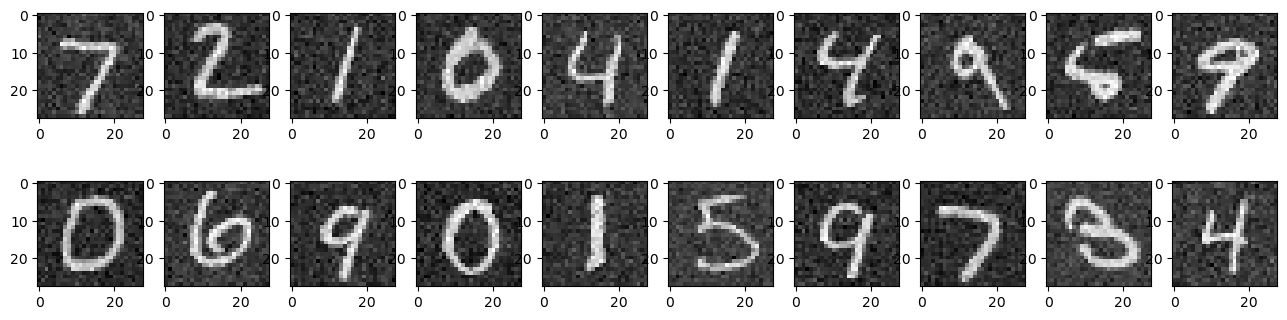

In [56]:
visualize_data(X_test_noise[:20], 2, 10)

In [57]:
pred = cbdnet.predict(X_test[:20])
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


(20, 28, 28, 1)

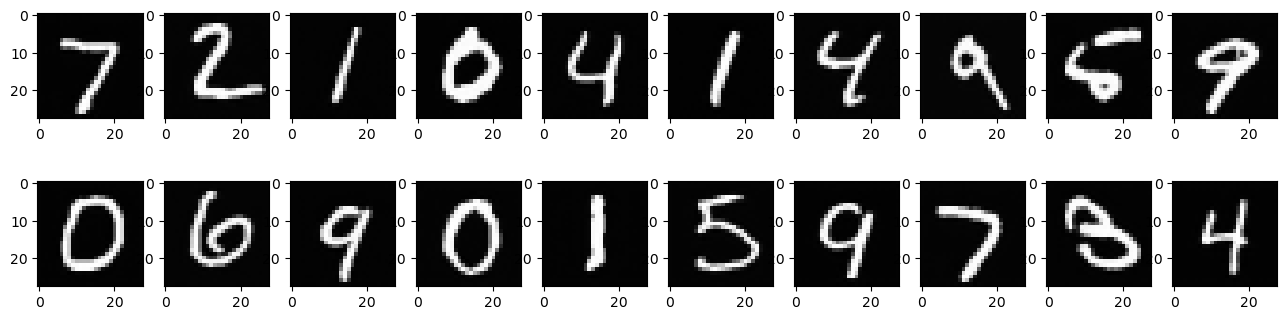

In [58]:
visualize_data(pred, 2, 10)

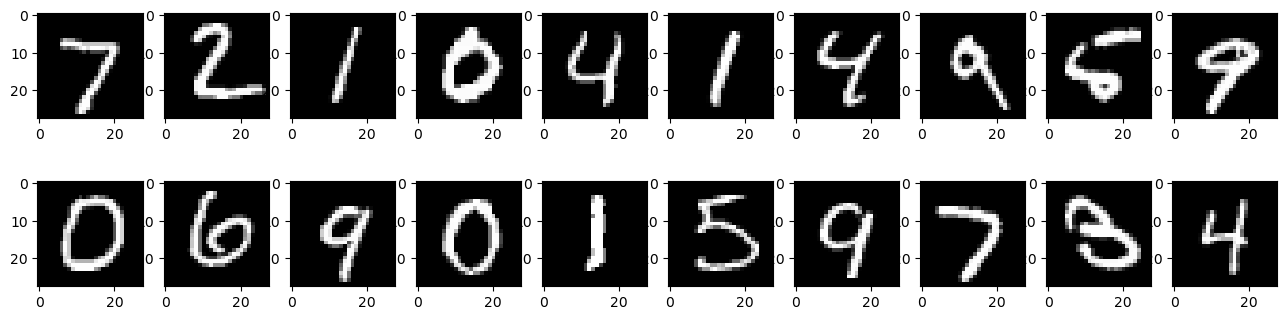

In [59]:
visualize_data(X_test[:20], 2, 10)